### В данном ноутбуке будет продемонстрирована работа аналитической модели канала, а также строятся графики, использующиеся в научных статьях

Импортируем все необходимые библиотеки, настроим флаги и константы, которыми будем пользоваться в эксперименте, и определим служебные функции

In [1]:
import os
import numpy as np
import numpy.linalg
import scipy
import scipy.special as special

from numpy import linalg as la

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from typing import Sequence, Tuple

In [2]:
#Подключаем локальные пакеты
from pysim import channel


In [3]:
DEFAULT_SPEED = 17             # Метры в секунду
DEFAULT_ORIENTATION = 'front'  # front or back
DEFAULT_ANGLE_DEG = 30         # angle in degrees
DEFAULT_FREQUENCY = 860.0      # reader frequency in MHz

FREQUENCY = 860_000_000
SPEED_OF_LIGHT = 299_792_458 #Метров в секунду
WAVELEN = SPEED_OF_LIGHT / FREQUENCY
THERMAL_NOISE = -114.0  # dBm

#Различные значения для поляризаций
VERTICAL_POLARIZATION = 0.0
HORIZONTAL_POLARIZATION = 1.0
CIRCULAR_POLARIZATION = 0.5

In [4]:
def to_sin(cos): #Дубликат!
    return (1 - cos ** 2) ** .5

def lin2db(value_linear):
    return 10 * np.log10(value_linear) if value_linear >= 1e-15 else -np.inf

def to_log(value, dbm=False, tol=1e-15): #Дубликат!
    return 10 * np.log10(value) + 30 * int(dbm) if value >= tol else -np.inf

def to_power(value, log=True, dbm=False): #Дубликат!
    power = np.abs(value) ** 2
    return to_log(power, dbm=dbm) if log else power

def deg2rad(a: float) -> float:
    """Перевести угол из градусов в радианы."""
    return a / 180.0 * np.pi

В данном случае считыватель смотрит вертикально вниз (по направлению оси -Z), а метка вертикально вверх (по направлению оси Z)



In [5]:
#Параметры считывателя
READER_POS = np.array((5.0, 0, 5.0)) # Положение в 3х мерном пространстве. (На высоте 5 метров)
READER_ANGLE = 0 #np.pi / 4 # Угол закрепления считывателя относительно оси -Z
READER_FORWARD = np.array((0, 0, -1)) #Куда смотрит антенна считывателя. (положительное направление оси X (влево))
READER_POLARIZATION = CIRCULAR_POLARIZATION # Выбираем тип поляризации антенны считывателя
READER_GAIN = 8
READER_CABLE_LOSS = -2.0
READER_NOISE = -80.0  # dBm
READER_TX_POWER = 31.5  # dBm
READER_SENSITIVITY = -80.0  # dBm

#Параметры метки
TAG_POS = np.array((5.0, -5, 0)) # Положение в 3х мерном пространстве.
TAG_FORWARD = np.array((0, 0, 1)) # Куда смотрит антенна метки
TAG_POLARIZATION = HORIZONTAL_POLARIZATION # Выбираем тип поляризации антенны метки
TAG_SENSITIVITY = -18.0
TAG_GAIN = 2.0
TAG_BACKSCATTER_LOSS = -10.0

# Параметры поверхности, от которой идёт отражение сигнала 
# В данном случае бетон влажностью около 5%

PERMITTIVITY = 6.1
CONDUCTIVITY = 0.0366

Функции, которые не объявлены в коде самого проекта будут описаны здесь

In [6]:
# def rp_dipole(*, azimuth, tol=1e-9, **kwargs):
#     a_sin = to_sin(azimuth)
#     return np.abs(np.cos(np.pi / 2 * a_sin) / azimuth) if azimuth > tol else 0.

In [7]:
# Функция, рассчитывающая потери в свободном пространстве
def free_space_path_loss_3d(
        *, time, wavelen,
        tx_pos, tx_dir_theta, tx_velocity, tx_rp,
        rx_pos, rx_dir_theta, rx_velocity, rx_rp,
        **kwargs):
    """
    Computes free space signal attenuation between the transmitter and the
    receiver in linear scale.
    :param wavelen: a wavelen of signal carrier
    :param time: Time passed from the start of reception (это константа!)
    :param tx_velocity: the velocity of the transmitter
    :param tx_dir_theta: the vector pointed the direction with azimuth
        angle equals 0 of the transmitter antenna.
    :param tx_pos: a current position of the transmitter.
    :param tx_rp: a radiation pattern of the transmitter
    :param rx_velocity: the velocity of the receiver
    :param rx_dir_theta: the vector pointed the direction with azimuth angle
        equals 0 of the transmitter antenna.
    :param rx_pos: a current position of the receiver
    :param rx_rp: a radiation pattern of the receiver
    :return: free space path loss in linear scale
    """
    d_vector = rx_pos - tx_pos
    d = la.norm(d_vector)
    d_vector_tx_n = d_vector / d
    d_vector_rx_n = -d_vector_tx_n

    # Azimuth angle computation for computation of attenuation
    # caused by deflection from polar direction
    tx_azimuth = np.dot(d_vector_tx_n, tx_dir_theta)
    rx_azimuth = np.dot(d_vector_rx_n, rx_dir_theta)

    relative_velocity = rx_velocity - tx_velocity
    velocity_pr = np.dot(d_vector_tx_n, relative_velocity)

    # Attenuation caused by radiation pattern
    g0 = (tx_rp(azimuth=tx_azimuth, wavelen=wavelen, **kwargs) *
          rx_rp(azimuth=rx_azimuth, wavelen=wavelen, **kwargs))

    k = 2 * np.pi / wavelen
    return (0.5/k)**2 * np.abs(g0/d*np.exp(-1j*k*(d - time * velocity_pr)))**2

Объявим заголовочные функции

In [8]:
# "Заголовочная" функция для рассчёта коэффициента отражения
# Используется только для постройки графиков
def get_reflection(a: float, pol: float, permittivity: float = PERMITTIVITY,
                   conductivity: float = CONDUCTIVITY, 
                   wavelen: float = WAVELEN) -> float:
    """
    Расчитать коэффициент отражения.
    
    Args:
        a (float): угол падения
        pol (float): поляризация
        permittivity (float)
        conductivity (float)
        wavelen (float)
    """
    return abs(channel.reflection(
        cosine = np.cos(a),
        polarization=pol,
        permittivity=permittivity,
        conductivity=conductivity,
        wavelen=wavelen))

In [9]:
# "Заголовок" для функции потерь в свободном пространстве
def get_free_space_pathloss(x: float, v: float = 0, t: float = 0) -> float:
    """
    Рассчитать затухание в канале без отражений.
    
    Args:
        x (float): положение метки на оси OX
        v (float): скорость метки (по-умолчанию, 0)
        t (float): время со включения считывателя (по-умолчанию, 0)
    """
    return lin2db(free_space_path_loss_3d(
        time=t, wavelen=WAVELEN, 
        # Reader position, orientation and speed:
        tx_pos=READER_POS, 
        tx_dir_theta=READER_FORWARD,
        tx_rp=channel.rp_dipole,
        tx_velocity=np.zeros(3), #Скорость равна нолю
        # Tag position, orientation and speed:
        rx_pos=np.array((TAG_POS[0], x, TAG_POS[2])), #Тэг перемещается исключительно вдоль оси X
        rx_dir_theta=TAG_FORWARD,
        rx_rp=channel.rp_dipole,
        rx_velocity=(v * TAG_FORWARD), #Подразумевается, что тэг движется
    ))

In [10]:
# "Заголовок" для функции потрерь в случае двухлучевого распространения 
def get_pathloss(y: float, pol: float, v: float = DEFAULT_SPEED, t: float = 0.1) -> float:
    """
    Рассчитать затухание в канале. Значения затухания будут разными
    для каналов от считывателя к метке и обратно только из-за поляризации,
    так как от нее зависит коэффициент отражения. Все остальное - симметрично.
    
    Args:
        x (float): положение метки на оси OX
        pol (float): поляризация передающей стороны
        v (float): скорость метки (по-умолчанию, 0)
        t (float): время со включения считывателя (по-умолчанию, 0)
    """
    return lin2db(channel.two_ray_pathloss(
        time=t, wavelen=WAVELEN, 
        # Reader position, orientation and speed:
        tx_pos=READER_POS, 
        tx_dir_theta=READER_FORWARD,
        tx_rp=channel.rp_dipole,    #ДН диполя
        tx_velocity=np.zeros(3),
        polarization=pol,
        # Tag position, orientation and speed:
        rx_pos=np.array((TAG_POS[0], y, TAG_POS[2])),
        rx_dir_theta=TAG_FORWARD,
        rx_rp=channel.rp_dipole,    #ДН диполя
        rx_velocity = np.array((0, v, 0)),
        # Ground reflection:
        ground_reflection=channel.reflection, 
        conductivity=CONDUCTIVITY, 
        permittivity=PERMITTIVITY,
        # Неиспользуемые в функции переменные
        tx_dir_phi = 0,
        rx_dir_phi = 0,
        crutch = True
    ))

Функции, которые не объявлены в коде самого проекта будут описаны здесь

### Построим нужные графики

Графики, иллюстрирующие значения коэффициента отражения для разных видов поляризации

In [11]:
oa = np.linspace(0.1, 89.9, 200)
rv = [get_reflection(deg2rad(a), VERTICAL_POLARIZATION) for a in oa]
rc = [get_reflection(deg2rad(a), CIRCULAR_POLARIZATION) for a in oa]
rh = [get_reflection(deg2rad(a), HORIZONTAL_POLARIZATION) for a in oa]

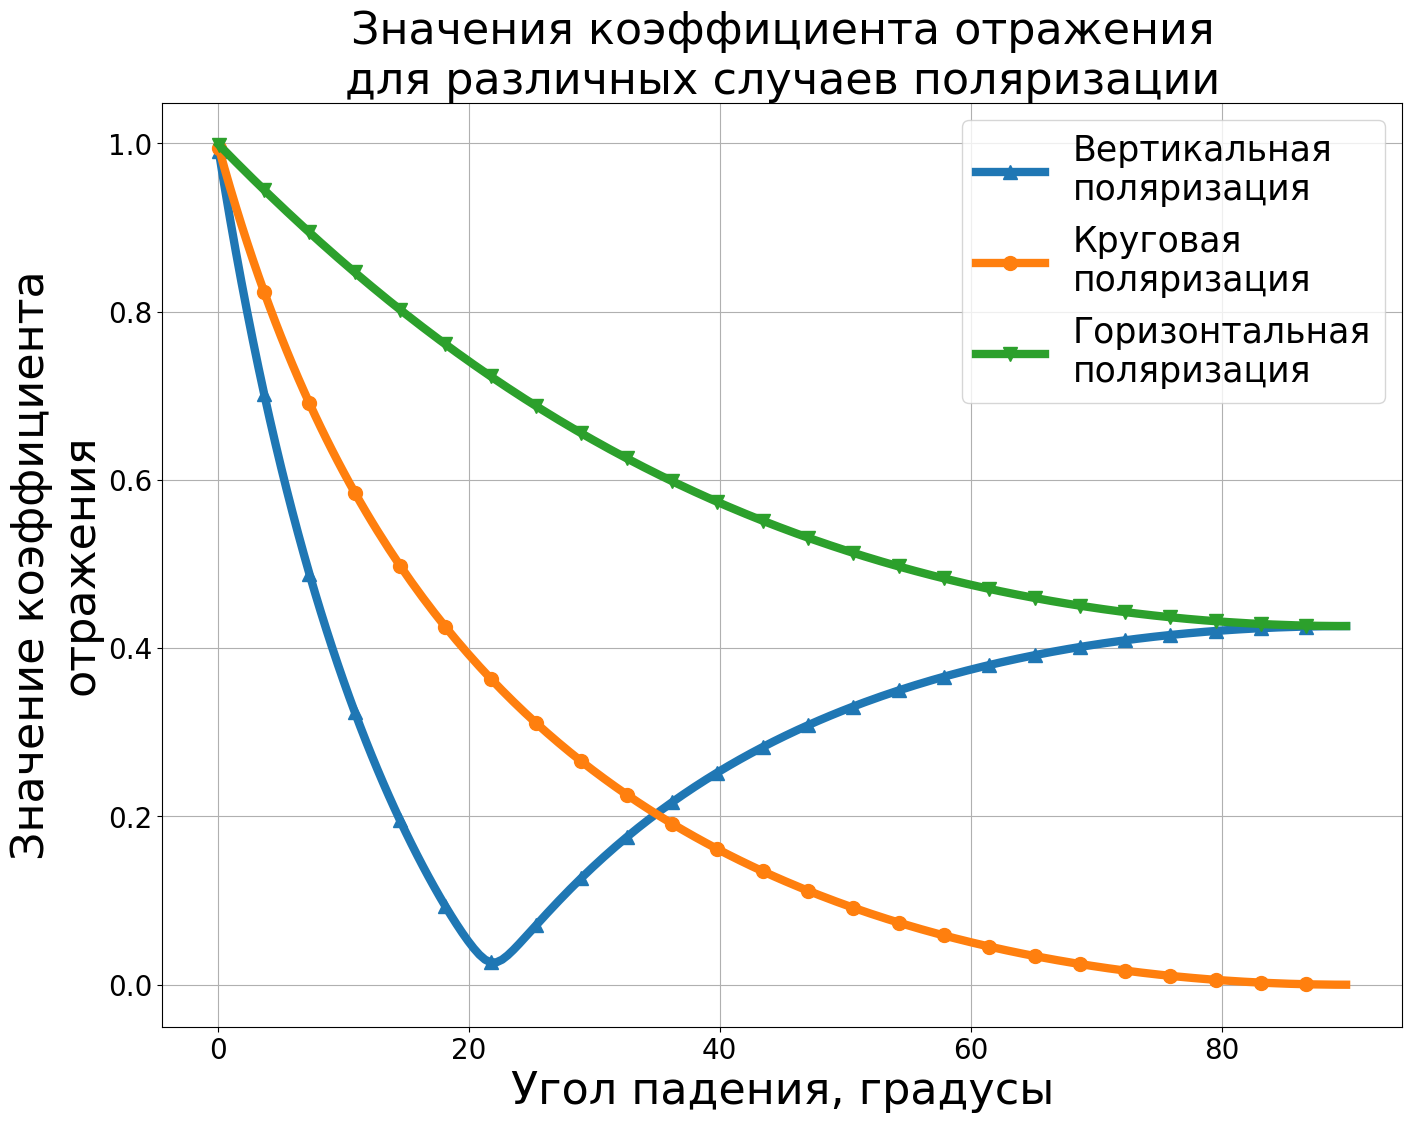

In [12]:
fig, ax0 = plt.subplots(1, 1, num = 0, figsize=(16, 12))
ax0.plot(oa, rv, label="Вертикальная\nполяризация", linewidth=6, linestyle='-', marker='^', markevery=8, markersize=10)
ax0.plot(oa, rc, label="Круговая\nполяризация", linewidth=6, linestyle='-', marker='o', markevery=8, markersize=10)
ax0.plot(oa, rh, label="Горизонтальная\nполяризация", linewidth=6, linestyle='-', marker='v', markevery=8, markersize=10)
ax0.set_title("Значения коэффициента отражения\nдля различных случаев поляризации", fontsize=32)
ax0.set_xlabel("Угол падения, градусы", fontsize=32)
ax0.set_ylabel("Значение коэффициента\nотражения", fontsize=32)
ax0.grid()
ax0.tick_params(axis='both', which='major', labelsize=20)
leg = ax0.legend(prop={"size":25})
#fig.legend(loc='center right', bbox_to_anchor=(1, 0.5))
# fig.savefig('R_coeff.png')

In [13]:
# Диапазон движения метки
ox = np.linspace(-10, 10, 200)

# Непосредственно рассчёт значений потерь
READER_POS = np.array((TAG_POS[0], 0, 5.0))
y0 = [get_free_space_pathloss(x, 0, 0) for x in ox] # Однолучевой случай, расстояние до стены не существует

READER_POS = np.array((3, 0, 5.0))
yv_3 = [get_pathloss(x, READER_POLARIZATION) for x in ox] # Включать для 1го метра

READER_POS = np.array((TAG_POS[0], 0, 5.0))
yv_up_tag = [get_pathloss(x, READER_POLARIZATION) for x in ox] # Включать для 3х метров

READER_POS = np.array((5.0, 0, 5.0))
yv_5 = [get_pathloss(x, READER_POLARIZATION) for x in ox] # Включать для 5ти метров

READER_POS = np.array((8.0, 0, 5.0))
yv_8 = [get_pathloss(x, READER_POLARIZATION) for x in ox] #Включать для 8 метров

READER_POS = np.array((12.0, 0, 5.0))
yv_12 = [get_pathloss(x, READER_POLARIZATION) for x in ox] #Включать для 12 метров

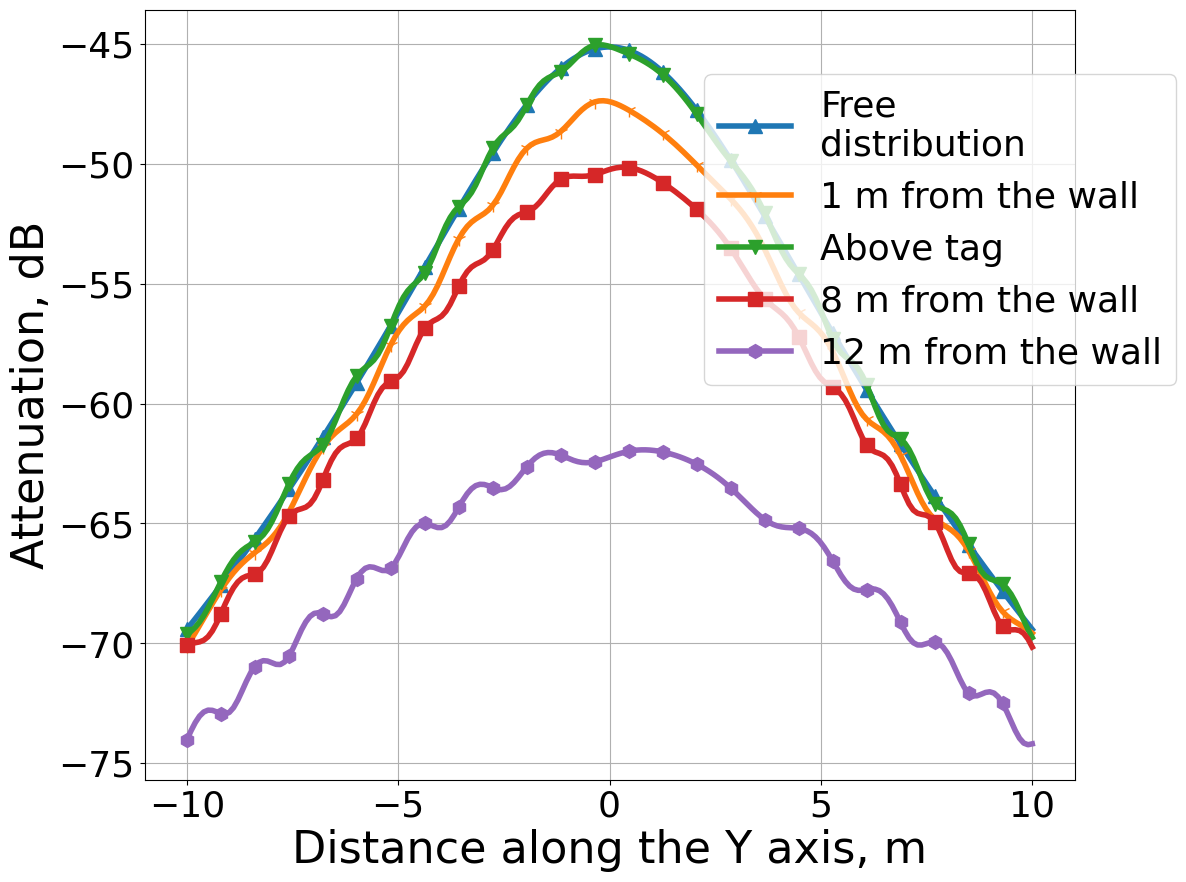

In [14]:
# Графики для потерь от считывателя к метке
fig, ax = plt.subplots(1, 1, num = 1, figsize=(12, 10))
ax.plot(ox, y0, label="Free\ndistribution", linewidth=4, linestyle='-', marker='^', markevery=8, markersize=10)
ax.plot(ox, yv_3, label="1 m from the wall", linewidth=4, linestyle='-', marker='1', markevery=8, markersize=10)
ax.plot(ox, yv_up_tag, label="Above tag", linewidth=4, linestyle='-', marker='v', markevery=8, markersize=10)
# ax.plot(ox, yv_5, label="Отражение 5 м", linewidth=4, linestyle='-', marker='o', markevery=8, markersize=10)
ax.plot(ox, yv_8, label="8 m from the wall", linewidth=4, linestyle='-', marker='s', markevery=8, markersize=10)
ax.plot(ox, yv_12, label="12 m from the wall", linewidth=4, linestyle='-', marker='h', markevery=8, markersize=10)
# ax.set_title("Потери в канале (от считывателя к метке)", fontsize=32)
ax.set_xlabel("Distance along the Y axis, m", fontsize=32)
ax.set_ylabel("Attenuation, dB", fontsize=32)
fig.legend(loc='center right', bbox_to_anchor=(1, 0.66), fontsize=26)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=26)
# leg = ax.legend(prop={"size":25})
fig.savefig('PL.png')

Далее сделаем расчёт мощностей сигналов и построим график. Здесь будут описаны функции, так как в библиотеке нет нужных

In [27]:
READER_POS = np.array((8.0, 0, 5.0)) # Немного сдвинем считыватель, чтобы построился график

In [21]:
def get_tag_rx(x: float, v: float, t: float, 
               tx: float = READER_TX_POWER) -> float:
    """
    Вычислить мощность сигнала, принятого меткой.
    От считывателя к метке.
    """
    path_loss = get_pathloss(x, READER_POLARIZATION, v, t)
    # pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    if (READER_POLARIZATION == TAG_POLARIZATION):
        pol_loss = 0
    elif (np.abs(READER_POLARIZATION - TAG_POLARIZATION) > 0.1 and np.abs(READER_POLARIZATION - TAG_POLARIZATION) < 0.6):
        pol_loss = -3
    elif (np.abs(READER_POLARIZATION - TAG_POLARIZATION) == 1):
        pol_loss = -100
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [22]:
def get_tag_tx(rx: float):
    """
    Вычислить мощность сигнала, отраженного меткой.
    От метки к считывателю без потерь на распространение.
    """
    return rx + TAG_BACKSCATTER_LOSS

In [23]:
def get_reader_rx(x: float, v: float, t: float, tx: float) -> float:
    """
    Вычислить мощность сигнала, принятого считывателем.
    От метки к считывателю с учётом потерь в канале.
    """
    path_loss = get_pathloss(x, TAG_POLARIZATION, v, t)
    if (READER_POLARIZATION == TAG_POLARIZATION):
        pol_loss = 0
    elif (np.abs(READER_POLARIZATION - TAG_POLARIZATION) > 0.1 and np.abs(READER_POLARIZATION - TAG_POLARIZATION) < 0.6):
        pol_loss = -3
    elif (np.abs(READER_POLARIZATION - TAG_POLARIZATION) == 1):
        pol_loss = -100
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [24]:
def find_zones(
        x: Sequence[float], 
        y: Sequence[float], 
        bound: float, 
        use_upper: bool = True
) -> Sequence[Tuple[float, float]]:
    """
    Найти интервалы на X, внутри которых значение Y выше или ниже лимита.
    
    Например, если use_upper = True, то есть ищем интервалы выше лимита, то
    возвращает набор интервалов `[(x0, x1), (x2, x3), ...]`, таких, что:
    - для x[2n] <= x <= x[2n+1]: y(x) >= B
    - для x[2n+1] <= x <= x[2n+2]: y(x) <= B
    
    Размерности x и y должны совпадать.
    
    Args:
        x (sequence of float): последовательность аргументов
        y (sequence of float): последовательность значений
        bound (float): граничное значение
        use_upper (bool): если True, то ищем области, в которых значение выше
    
    Returns:
        intervals (sequence of tuples): последовательность интервалов
    """
    # Специально делаем так, чтобы изначально is_upper не совпадало с тем,
    # что будет в первой точке:
    is_upper = False
    x_left: Optional[float] = None
    intervals = []
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        
        is_start_point = False
        is_end_point = False

        if (not is_upper or (use_upper and i == 0)) and yi >= bound:

            # Если выполняется равенство, нужно проверить, возрастает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi > bound or i == len(x)-1 or y[i+1] >= bound:
                is_upper = True
                if use_upper:
                    is_start_point = True
                else:
                    is_end_point = True
                            
        elif (is_upper or (not use_upper and i == 0)) and yi <= bound:

            # Если выполняется равенство, нужно проверить, убывает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi < bound or i == len(y)-1 or y[i+1] <= bound:
                is_upper = False
                if use_upper:
                    is_end_point = True
                else:
                    is_start_point = True
        
        if is_start_point:
            x_left = xi
        if is_end_point:
            intervals.append((x_left, xi))
            x_left = None
    
    # После цикла проверяем, не надо ли закрыть интервал.
    if x_left is not None:
        intervals.append((x_left, x[-1]))
        
    return intervals

In [25]:
CMAP_NAME = 'inferno'  # Цветовая схема для графиков

def get_color(x: float):
    """
    Получить цвет из текущей карты.
    
    Args:
        x (float): число от 0 до 1
    
    Returns:
        color
    """
    return matplotlib.cm.get_cmap(CMAP_NAME)(x)

Zones where tag is off:  [(-15.0, -2.878787878787879), (3.1818181818181834, 15.0)]


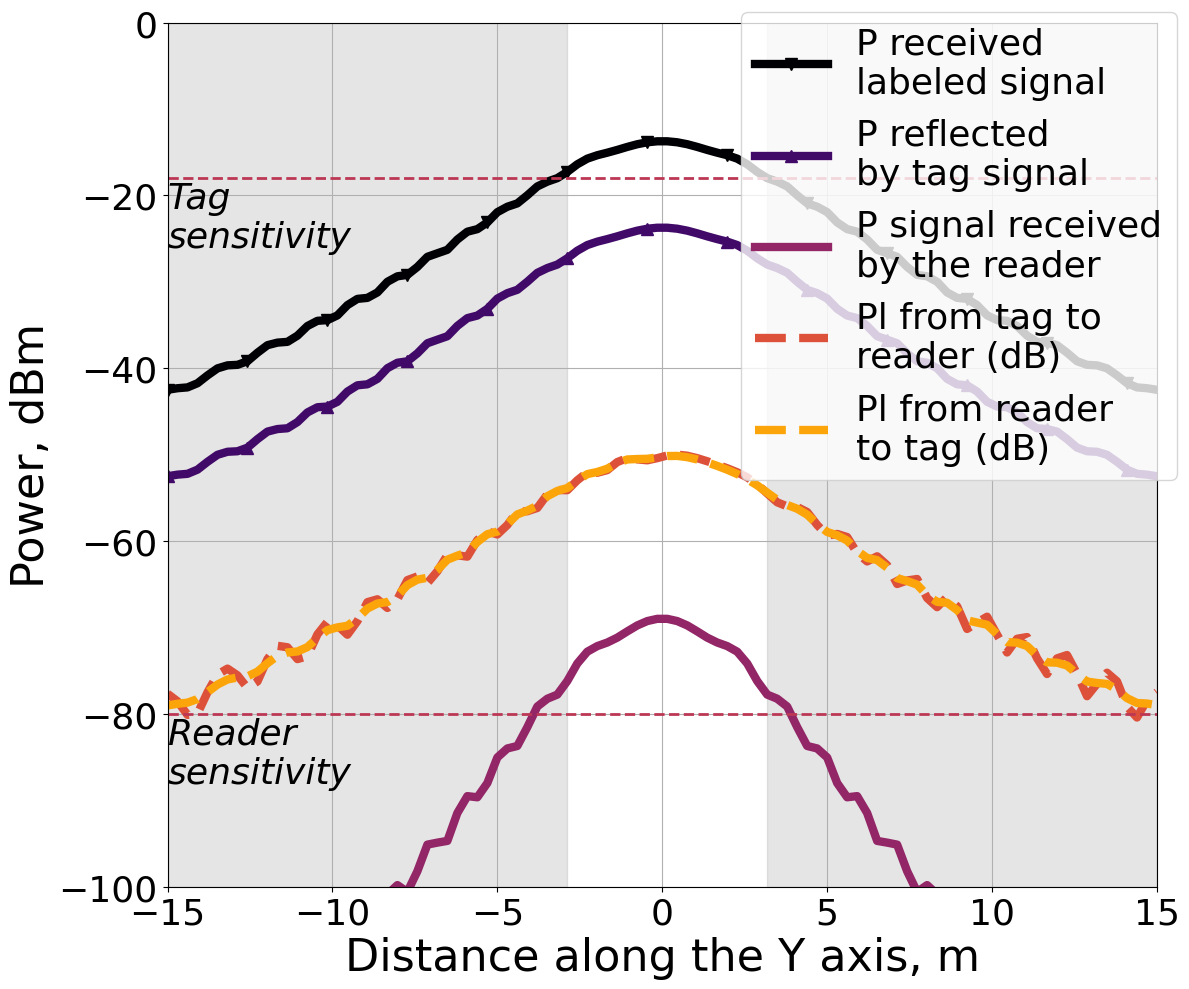

In [28]:
ox = np.linspace(-15, 15, 100)

tag_pl = [get_pathloss(x, TAG_POLARIZATION) for x in ox]
reader_pl = [get_pathloss(x, READER_POLARIZATION) for x in ox]
tag_rx = [get_tag_rx(x, 0, 0) for x in ox]
tag_tx = [get_tag_tx(rx) for rx in tag_rx]
reader_rx = [get_reader_rx(x, 0, 0, tx) for (x, tx) in zip(ox, tag_tx)]

y_min = -100
y_max = 0

fig, ax = plt.subplots(figsize=(12, 10), nrows=1, ncols=1)
    
ax.plot(ox, tag_rx, label="P received\nlabeled signal",
    linewidth=6, linestyle='-', marker='v', markevery=8, markersize=8,
    color=get_color(0))
ax.plot(ox, tag_tx, label="P reflected\nby tag signal",
    linewidth=6, linestyle='-', marker='^', markevery=8, markersize=8,
    color=get_color(0.2))
ax.plot(ox, reader_rx, label="P signal received\nby the reader",
    linewidth=6, color=get_color(0.4))
ax.plot(ox, tag_pl, label="Pl from tag to \nreader (dB)",
    linestyle='--', color=get_color(0.6), linewidth=6)
ax.plot(ox, reader_pl, label="Pl from reader\nto tag (dB)",
    linestyle='--', color=get_color(0.8), linewidth=6)

# Нарисуем линии чувствительности метки и считывателя
ax.hlines(y=TAG_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
      colors=get_color(0.5), linestyles='--', linewidths=2)
ax.hlines(y=READER_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
      colors=get_color(0.5), linestyles='--', linewidths=2)

ax.text(x=-15, y=TAG_SENSITIVITY-8, s="Tag\nsensitivity", 
    fontdict={'style': 'italic'}, fontsize=26)
ax.text(x=-15, y=READER_SENSITIVITY-8, fontsize=26,
    s="Reader\nsensitivity", 
    fontdict={'style': 'italic'})

# Выделим области, в которых метка выключена
tag_off_intervals = find_zones(ox, tag_rx, TAG_SENSITIVITY, use_upper=False)
print("Zones where tag is off: ", tag_off_intervals)
for interval in tag_off_intervals:
    ax.add_patch(patches.Rectangle(xy=(interval[0], y_min), 
        width=(interval[1] - interval[0]), 
        height=(y_max - y_min),
        fill=True, color='gray', alpha=0.2))    

ax.set_xlim((-15, ox[-1]))
ax.set_ylim((y_min, y_max))
ax.grid()
ax.set_xlabel("Distance along the Y axis, m", fontsize=32)
ax.set_ylabel("Power, dBm", fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=26)
    
handles, labels = ax.get_legend_handles_labels()
patch = patches.Patch(color='grey', alpha=0.5)
handles.append(patch)

labels.append("Area where\ntag is disabled")
    
fig.legend(bbox_to_anchor=(1, 1), fontsize=26)
# ax.set_title("Бюджет канала", fontsize=32)
    
plt.tight_layout()
    
# fig.savefig('budget.png')